# Бета-Банк

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

**Цель проекта:**

    Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 
    Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Импортируем библиотеки.

In [126]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

Убрираем длинные циферки.

In [127]:
pd.set_option('display.float_format', '{:,.3f}'.format)

### Открывавем и и изучаем файл.

In [128]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    ! gdown --id 1fkzk2Q6VOtjKqHQYc6klqrhTSnknd1dM
    df = pd.read_csv('/content/Churn.csv')

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1fkzk2Q6VOtjKqHQYc6klqrhTSnknd1dM
To: /content/Churn.csv
100% 710k/710k [00:00<00:00, 117MB/s]


Смотрим табличку.

In [129]:
display(df)
print()
display(df.columns)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.000,0.000,1,1,1,"101,348.880",1
1,2,15647311,Hill,608,Spain,Female,41,1.000,"83,807.860",1,0,1,"112,542.580",0
2,3,15619304,Onio,502,France,Female,42,8.000,"159,660.800",3,1,0,"113,931.570",1
3,4,15701354,Boni,699,France,Female,39,1.000,0.000,2,0,0,"93,826.630",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.000,"125,510.820",1,1,1,"79,084.100",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.000,0.000,2,1,0,"96,270.640",0
9996,9997,15569892,Johnstone,516,France,Male,35,10.000,"57,369.610",1,1,1,"101,699.770",0
9997,9998,15584532,Liu,709,France,Female,36,7.000,0.000,1,0,1,"42,085.580",1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.000,"75,075.310",2,1,0,"92,888.520",1


Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

Переименовываем столбцы:

In [130]:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
display(df.columns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

### Описание данных

Признаки

    • row_number                    — индекс строки в данных
	• customer_id      — id_клиента — уникальный идентификатор клиента
	• surname          — фамилия    — фамилия
	• credit_score     — кред_рейт  — кредитный рейтинг
	• geography        — страна     — страна проживания
	• gender           — пол        — пол
	• age              — возраст    — возраст
	• tenure           — лет_клиент — сколько лет человек является клиентом банка
	• balance          — баланс     — баланс на счёте
	• num_of_products  — кол_прод   — количество продуктов банка, используемых клиентом
	• has_cr_card      — кред_карт  — наличие кредитной карты
	• isactivemember   — активность — активность клиента
	• estimated_salary — зарплата   — предполагаемая зарплата

Целевой признак

	• exited           — уход       — факт ухода клиента!

Табличку к рабочему виду:

In [131]:
df_rus = df.rename(columns={'row_number': 'индекс_стр',
                            'customer_id': 'id_клиента',
                            'surname': 'фамилия',
                            'credit_score': 'кред_рейт',
                            'geography': 'страна',
                            'gender': 'пол',
                            'age': 'возраст',
                            'tenure': 'лет_клиент',
                            'balance': 'баланс',
                            'num_of_products': 'кол_прод',
                            'has_cr_card': 'кред_карт',
                            'is_active_member': 'активность',
                            'estimated_salary': 'зарплата',
                            'exited': 'уход'})
display(df_rus)

,индекс_стр,id_клиента,фамилия,кред_рейт,страна,пол,возраст,лет_клиент,баланс,кол_прод,кред_карт,активность,зарплата,уход
0,1,15634602,Hargrave,619,France,Female,42,2.000,0.000,1,1,1,"101,348.880",1
1,2,15647311,Hill,608,Spain,Female,41,1.000,"83,807.860",1,0,1,"112,542.580",0
2,3,15619304,Onio,502,France,Female,42,8.000,"159,660.800",3,1,0,"113,931.570",1
3,4,15701354,Boni,699,France,Female,39,1.000,0.000,2,0,0,"93,826.630",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.000,"125,510.820",1,1,1,"79,084.100",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.000,0.000,2,1,0,"96,270.640",0
9996,9997,15569892,Johnstone,516,France,Male,35,10.000,"57,369.610",1,1,1,"101,699.770",0
9997,9998,15584532,Liu,709,France,Female,36,7.000,0.000,1,0,1,"42,085.580",1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.000,"75,075.310",2,1,0,"92,888.520",1


### Инфо. Пропуски. Описание.

Посмотрим заполненость таблицы.

In [132]:
print('\nИнфо:')                                   # сколько значений и в каком формате
print(df_rus.info())
print('\nПропусков:')                              # подсчёт пропусков в долях
print(df_rus.isna().mean())
print('\ndescribe:')                               # вдруг чего "на глазок" проявится 
display(df_rus.describe())
print('\nДубликатов =', df_rus.duplicated().sum()) # проверим дубликаты


Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   индекс_стр  10000 non-null  int64  
 1   id_клиента  10000 non-null  int64  
 2   фамилия     10000 non-null  object 
 3   кред_рейт   10000 non-null  int64  
 4   страна      10000 non-null  object 
 5   пол         10000 non-null  object 
 6   возраст     10000 non-null  int64  
 7   лет_клиент  9091 non-null   float64
 8   баланс      10000 non-null  float64
 9   кол_прод    10000 non-null  int64  
 10  кред_карт   10000 non-null  int64  
 11  активность  10000 non-null  int64  
 12  зарплата    10000 non-null  float64
 13  уход        10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None

Пропусков:
индекс_стр   0.000
id_клиента   0.000
фамилия      0.000
кред_рейт    0.000
страна       0.000
пол          0.000
возраст      0.000
лет_клиент   0.09

,индекс_стр,id_клиента,кред_рейт,возраст,лет_клиент,баланс,кол_прод,кред_карт,активность,зарплата,уход
count,"10,000.000","10,000.000","10,000.000","10,000.000","9,091.000","10,000.000","10,000.000","10,000.000","10,000.000","10,000.000","10,000.000"
mean,"5,000.500","15,690,940.569",650.529,38.922,4.998,"76,485.889",1.530,0.706,0.515,"100,090.240",0.204
std,"2,886.896","71,936.186",96.653,10.488,2.895,"62,397.405",0.582,0.456,0.500,"57,510.493",0.403
min,1.000,"15,565,701.000",350.000,18.000,0.000,0.000,1.000,0.000,0.000,11.580,0.000
25%,"2,500.750","15,628,528.250",584.000,32.000,2.000,0.000,1.000,0.000,0.000,"51,002.110",0.000
50%,"5,000.500","15,690,738.000",652.000,37.000,5.000,"97,198.540",1.000,1.000,1.000,"100,193.915",0.000
75%,"7,500.250","15,753,233.750",718.000,44.000,7.000,"127,644.240",2.000,1.000,1.000,"149,388.247",0.000
max,"10,000.000","15,815,690.000",850.000,92.000,10.000,"250,898.090",4.000,1.000,1.000,"199,992.480",1.000



Дубликатов = 0


##### Вывод

    - Количество записей 10000.
    - С форматом данных все ровно.
    - Есть пропуски в
        - tenure — сколько лет человек является клиентом банка
      Если потребуется удалить строки с пропусками, то 9091 оставшейся будет достаточно для исследования.
    - Дубликатов нет.
    - Разброс параметров и очевидные аномалии оценим в следующем разделе.

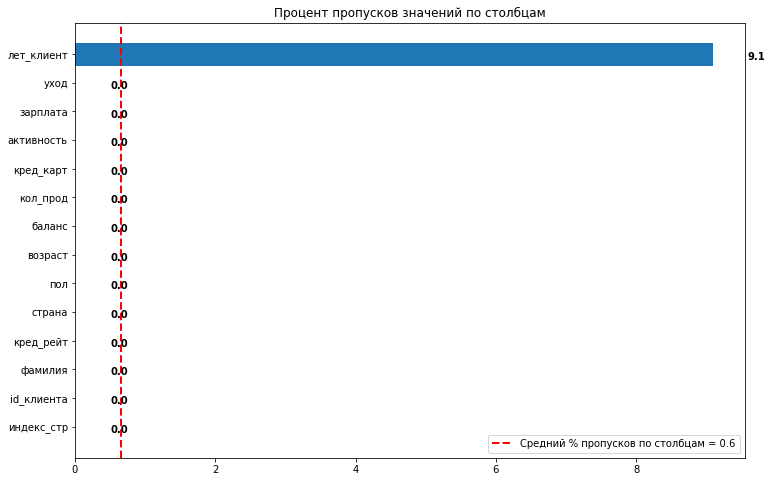

In [133]:
columns = df_rus.columns.values.tolist()
nan = []
for col in columns:
    not_nan_count = df_rus[col].count()
    percent = ((len(df_rus) - not_nan_count) / len(df_rus)) * 100
    nan.append(percent)
nan_percent_before = pd.Series(nan,
                               index = columns)
nan_percent_before_mean = nan_percent_before.mean()
nan_percent_before.sort_values(ascending=True,
                               inplace=True)
fig, ax = plt.subplots(figsize=(12,8))
ax.barh(nan_percent_before.index,
        nan_percent_before.values)
ax.set_title('Процент пропусков значений по столбцам')
# Добавим на график цифры значений
for i in ax.patches:
    plt.text(i.get_width()+0.5,
             i.get_y()+0.2,
             str(round(i.get_width(),1)),
             fontsize=10,
             fontweight='bold',
             color='black')
# Построим линию, показывающую средний % пропусков по столбцам
plt.axvline(x=nan_percent_before_mean,
            linewidth=2,
            label='Средний % пропусков по столбцам = {}'.format(round(nan_percent_before_mean, 1)),
            color='r',
            linestyle='--')
plt.legend()
plt.show()

Посмотрим корреляцию значений столбцов друг с другом.

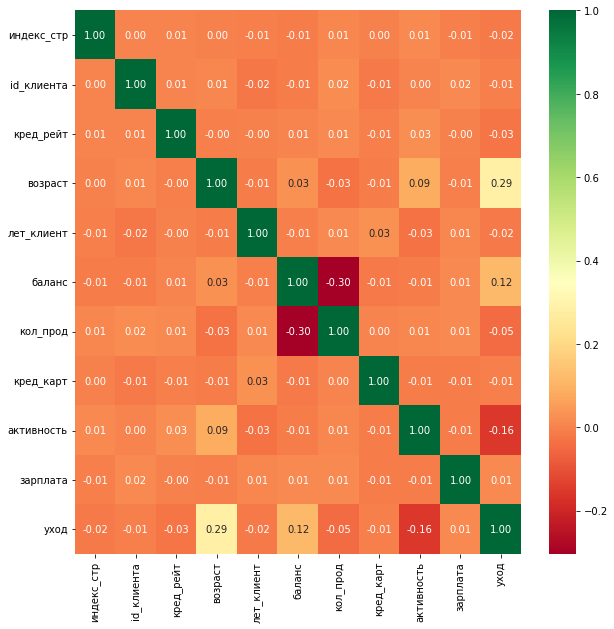

In [134]:
plt.figure(figsize=(10,10))
sns.heatmap(df_rus.corr(),
            annot=True,
            cmap='RdYlGn',
            fmt='.2f')
plt.show()

### Проверка данных

#### индекс_стр

'Значения индекс_стр:'

array([    1,     2,     3, ...,  9998,  9999, 10000])


Количество "индекс_стр": 10000



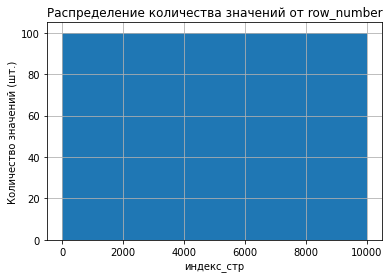

In [135]:
display('Значения индекс_стр:', df['row_number'].sort_values().unique())
print('\nКоличество "индекс_стр":', len(df['row_number'].unique()))
print()
display(df['row_number'].hist(bins=100))
plt.title("Распределение количества значений от row_number")
plt.xlabel("индекс_стр")
plt.ylabel("Количество значений (шт.)")
plt.show()

#### id_клиента

'Значения id_клиента:'

array([15565701, 15565706, 15565714, ..., 15815656, 15815660, 15815690])


Количество "id_клиента"= 10000



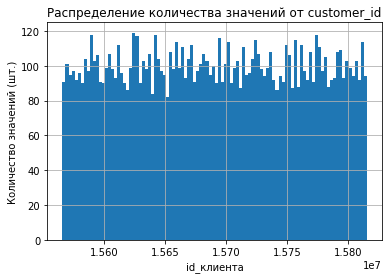

In [136]:
display('Значения id_клиента:', df['customer_id'].sort_values().unique())
print('\nКоличество "id_клиента"=', len(df['customer_id'].unique()))
print()
display(df['customer_id'].hist(bins=100))
plt.title("Распределение количества значений от customer_id")
plt.xlabel("id_клиента")
plt.ylabel("Количество значений (шт.)")
plt.show()

#### фамилия

In [137]:
with pd.option_context('display.max_rows', None):
    display(pd.Series(df['surname']
                      .sort_values()
                      .unique()
                      ).to_frame()
                      .rename(columns={0 : 'фамилия'}))

,фамилия
0,Abazu
1,Abbie
2,Abbott
3,Abdullah
4,Abdulov
5,Abel
6,Abernathy
7,Abramov
8,Abramova
9,Abramovich


#### кред_рейт

'Значения кред_рейт:'

array([350, 351, 358, 359, 363, 365, 367, 373, 376, 382, 383, 386, 395,
       399, 401, 404, 405, 407, 408, 410, 411, 412, 413, 414, 415, 416,
       417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429,
       430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
       443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455,
       456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468,
       469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
       482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
       495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507,
       508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520,
       521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533,
       534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546,
       547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559,
       560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 57

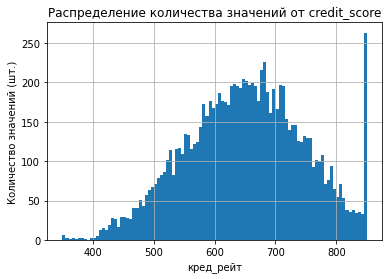

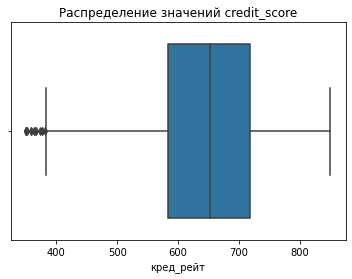

In [138]:
display('Значения кред_рейт:', df['credit_score'].sort_values().unique())
print()
display(df['credit_score'].hist(bins=100))
plt.title("Распределение количества значений от credit_score")
plt.xlabel("кред_рейт")
plt.ylabel("Количество значений (шт.)")
plt.show()
display(ax = sns.boxplot(data = df,
                         x = 'credit_score',
                         orient = 'h'))
plt.title("Распределение значений credit_score")
plt.xlabel("кред_рейт")
plt.show()

#### страна

'Значения страна:'

array(['France', 'Germany', 'Spain'], dtype=object)

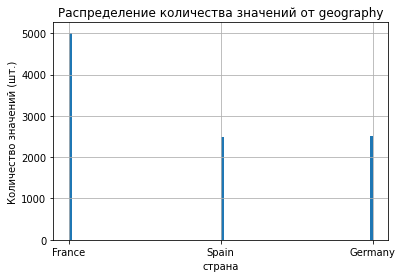

In [139]:
display('Значения страна:', df['geography'].sort_values().unique())
print()
display(df['geography'].hist(bins=100))
plt.title("Распределение количества значений от geography")
plt.xlabel("страна")
plt.ylabel("Количество значений (шт.)")
plt.show()

#### пол

'Значения пол:'

array(['Female', 'Male'], dtype=object)

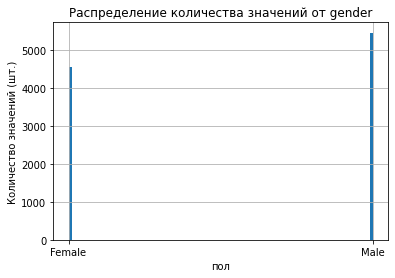

In [140]:
display('Значения пол:', df['gender'].sort_values().unique())
print()
display(df['gender'].hist(bins=100))
plt.title("Распределение количества значений от gender")
plt.xlabel("пол")
plt.ylabel("Количество значений (шт.)")
plt.show()

#### возраст

'Значения возраст:'

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       88, 92])

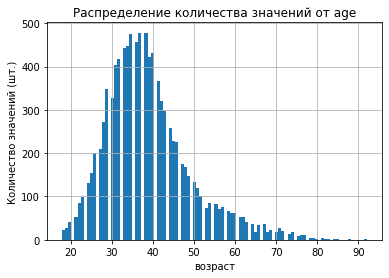

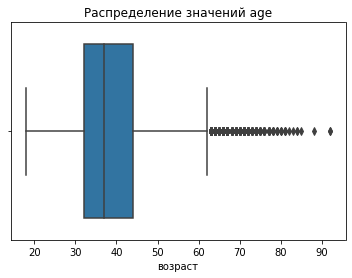

In [141]:
display('Значения возраст:', df['age'].sort_values().unique())
print()
display(df['age'].hist(bins=100))
plt.title("Распределение количества значений от age")
plt.xlabel("возраст")
plt.ylabel("Количество значений (шт.)")
plt.show()
display(ax = sns.boxplot(data = df,
                         x = 'age',
                         orient = 'h'))
plt.title("Распределение значений age")
plt.xlabel("возраст")
plt.show()

#### лет_клиент

'Значения лет_клиент:'

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., nan])

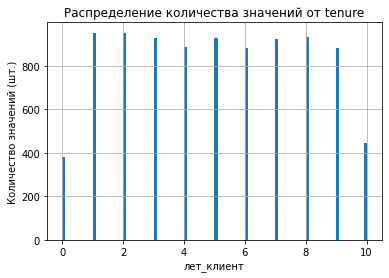

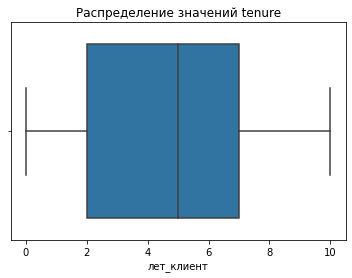

In [142]:
display('Значения лет_клиент:', df['tenure'].sort_values().unique())
print()
display(df['tenure'].hist(bins=100))
plt.title("Распределение количества значений от tenure")
plt.xlabel("лет_клиент")
plt.ylabel("Количество значений (шт.)")
plt.show()
display(ax = sns.boxplot(data = df,
                         x = 'tenure',
                         orient = 'h'))
plt.title("Распределение значений tenure")
plt.xlabel("лет_клиент")
plt.show()

#### баланс

'Значения баланс:'

array([     0.  ,   3768.69,  12459.19, ..., 222267.63, 238387.56,
       250898.09])

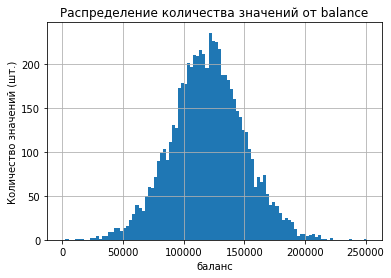

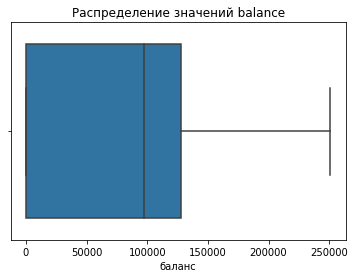

In [143]:
display('Значения баланс:', df['balance'].sort_values().unique())
print()
display(df['balance'].hist(bins=100,
                           range = (1, 251000))) # много нулевых значений
plt.title("Распределение количества значений от balance")
plt.xlabel("баланс")
plt.ylabel("Количество значений (шт.)")
plt.show()
display(ax = sns.boxplot(data = df,
                         x = 'balance',
                         orient = 'h'))
plt.title("Распределение значений balance")
plt.xlabel("баланс")
plt.show()

#### кол_прод

'Значения кол_прод:'

array([1, 2, 3, 4])

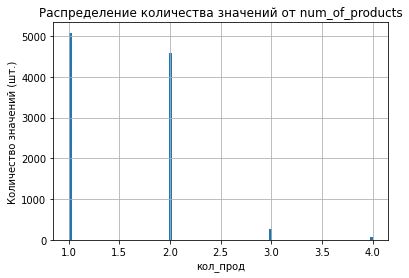

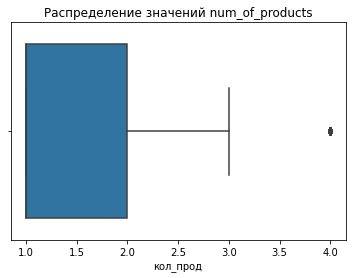

In [144]:
display('Значения кол_прод:', df['num_of_products'].sort_values().unique())
print()
display(df['num_of_products'].hist(bins=100))
plt.title("Распределение количества значений от num_of_products")
plt.xlabel("кол_прод")
plt.ylabel("Количество значений (шт.)")
plt.show()
display(ax = sns.boxplot(data = df,
                         x = 'num_of_products',
                         orient = 'h'))
plt.title("Распределение значений num_of_products")
plt.xlabel("кол_прод")
plt.show()

#### кред_карт

'Значения кред_карт:'

array([0, 1])

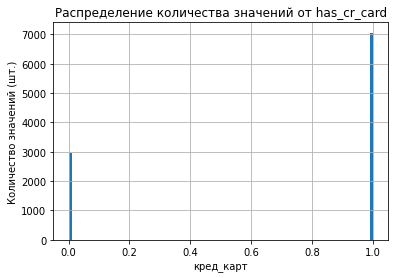

In [145]:
display('Значения кред_карт:', df['has_cr_card'].sort_values().unique())
print()
display(df['has_cr_card'].hist(bins=100))
plt.title("Распределение количества значений от has_cr_card")
plt.xlabel("кред_карт")
plt.ylabel("Количество значений (шт.)")
plt.show()

#### активность

'Значения активность:'

array([0, 1])

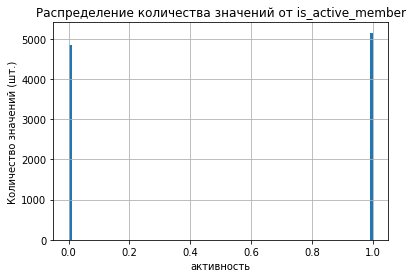

In [146]:
display('Значения активность:', df['is_active_member'].sort_values().unique())
print()
display(df['is_active_member'].hist(bins=100))
plt.title("Распределение количества значений от is_active_member")
plt.xlabel("активность")
plt.ylabel("Количество значений (шт.)")
plt.show()

#### зарплата

'Значения зарплата:'

array([1.1580000e+01, 9.0070000e+01, 9.1750000e+01, ..., 1.9995333e+05,
       1.9997074e+05, 1.9999248e+05])

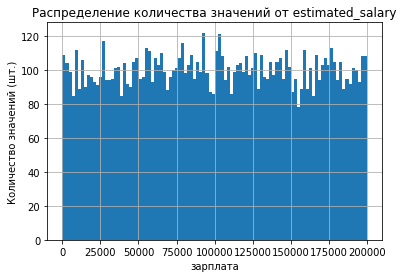

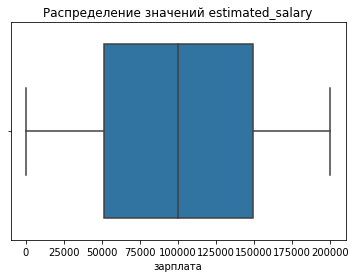

In [147]:
display('Значения зарплата:', df['estimated_salary'].sort_values().unique())
print()
display(df['estimated_salary'].hist(bins=100))
plt.title("Распределение количества значений от estimated_salary")
plt.xlabel("зарплата")
plt.ylabel("Количество значений (шт.)")
plt.show()
display(ax = sns.boxplot(data = df,
                         x = 'estimated_salary',
                         orient = 'h'))
plt.title("Распределение значений estimated_salary")
plt.xlabel("зарплата")
plt.show()

#### уход

'Значения уход:'

array([0, 1])

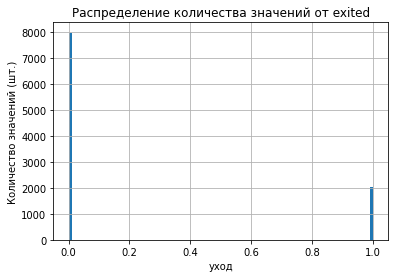

In [148]:
display('Значения уход:', df['exited'].sort_values().unique())
print()
display(df['exited'].hist(bins=100))
plt.title("Распределение количества значений от exited")
plt.xlabel("уход")
plt.ylabel("Количество значений (шт.)")
plt.show()

##### Вывод

    - Аномалий нет.
    - Выбросов и ошибок не наблюдается.
    - Пол и страну лучше перевести в числа, пригодится.
    - Колонку "Фамилия" в признаки не включать.

## Исследование задачи

Колонку "Фамилия" в словарик, на всякий случай.

In [149]:
surname_ed = df['surname'].unique()
customer_id_ed = df['customer_id'].unique()
surname_dict = dict(zip(surname_ed, customer_id_ed))

Лишние колонки удаляем.

Фамилии ('surname') удаляем, так как это точно дублирует id_клиента ('customer_id').

Остальные признаки определяем по окончании исследования так чтобы это увеличило точность предсказания.

In [150]:
df.pop('surname')
df.pop('row_number')
df.pop('customer_id')
display(df.columns)

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

Пол и страну переводим в числа.

In [151]:
df = pd.get_dummies(df, drop_first=True)
df

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.000,0.000,1,1,1,"101,348.880",1,0,0,0
1,608,41,1.000,"83,807.860",1,0,1,"112,542.580",0,0,1,0
2,502,42,8.000,"159,660.800",3,1,0,"113,931.570",1,0,0,0
3,699,39,1.000,0.000,2,0,0,"93,826.630",0,0,0,0
4,850,43,2.000,"125,510.820",1,1,1,"79,084.100",0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.000,0.000,2,1,0,"96,270.640",0,0,0,1
9996,516,35,10.000,"57,369.610",1,1,1,"101,699.770",0,0,0,1
9997,709,36,7.000,0.000,1,0,1,"42,085.580",1,0,0,0
9998,772,42,3.000,"75,075.310",2,1,0,"92,888.520",1,1,0,1


"Шапку" к стандартному виду.

In [152]:
df.columns = df.columns.str.lower()
display(df.columns)

Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary', 'exited',
       'geography_germany', 'geography_spain', 'gender_male'],
      dtype='object')

Удаляем nan, а то модели не обучатся.

In [153]:
df = df.dropna()

# Добавлено при исследовании моделей.
# Меняем nan, на 0
# df = df.fillna(0)
# df = df.fillna(df['tenure'].median())

print("Сделано!")

Сделано!


### Выделяем признаки

In [154]:
target = df['exited']
features = df.drop('exited', axis=1)

Выделаем тестовую выборку.

In [155]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.20, 
                                                                            random_state=1980)

Делим данные тренировочную и валидационную.

In [156]:
features_train, features_valid, target_train, target_valid = train_test_split(features_train, 
                                                                              target_train, 
                                                                              test_size=0.25, 
                                                                              random_state=1980)
print('features_train:', len(features_train),'шт')
print('features_valid:', len(features_valid),'шт')
print('features_test:', len(features_test),'шт')

features_train: 5454 шт
features_valid: 1818 шт
features_test: 1819 шт


Что у нас со значениями в 'exited' (целевом признаке):

0   0.796
1   0.204
Name: exited, dtype: float64



Text(0.5, 1.0, 'Частоты классов')

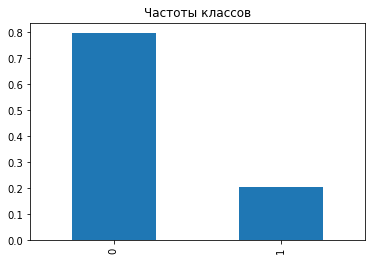

In [157]:
class_frequency = df['exited'].value_counts(normalize=True)
print(class_frequency)
print()
class_frequency.plot(kind='bar')
plt.title('Частоты классов')

Виден явный дисбаланс классов в пользу отрицательного класса в соотношении 4:1. Если мы будем всех людей прогнозировать, что они не уйдут из банка, то в 80% случаев мы будем правы.

### DecisionTreeClassifier

In [158]:
best_depth = 0
best_f1_score_dtс = 0
for depth in range(1, 6, 1):                   # проверялось до 50
    model = DecisionTreeClassifier(random_state=1980,
                                   max_depth=6)
    model.fit(features_train,
              target_train) 
    predicted_valid = model.predict(features_valid)
    f1_score_dtс = f1_score(target_valid,
                            predicted_valid)
    if f1_score_dtс > best_f1_score_dtс:
        best_f1_score_dtс = f1_score_dtс
        best_depth = depth
accuracy_valid_dtс = accuracy_score(target_valid,
                                    predicted_valid)
print('\nПравильность модели:')
print(accuracy_valid_dtс)
print('best_depth', best_depth)

print('\nМатрица ошибок:')
print(confusion_matrix(target_valid, predicted_valid))

recall_score_dtс = recall_score(target_valid, predicted_valid)
print('\nПолнота:')
print(recall_score_dtс)

precision_score_dtс = precision_score(target_valid, predicted_valid)
print('\nТочность:')
print(precision_score_dtс)

f1_score_dtс = f1_score(target_valid, predicted_valid)
print('\nF1-мера:')
print(f1_score_dtс)


Правильность модели:
0.8503850385038504
best_depth 1

Матрица ошибок:
[[1395   46]
 [ 226  151]]

Полнота:
0.4005305039787798

Точность:
0.766497461928934

F1-мера:
0.5261324041811846


Частоты классов в результатах предсказаний DecisionTreeClassifier.

'Частоты классов:'

0   0.892
1   0.108
dtype: float64

Text(0.5, 1.0, 'Частоты классов')

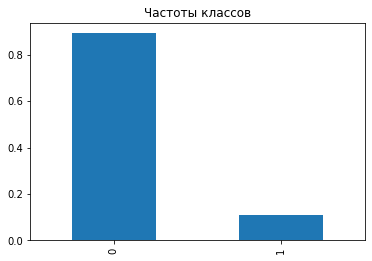

In [159]:
predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True)
display('Частоты классов:', class_frequency)
print()
class_frequency.plot(kind='bar')
plt.title('Частоты классов')

Константная модель: любому объекту она прогнозирует класс «0».

In [160]:
target_pred_constant = pd.Series(0, index=target.index)
accuracy_score_dtс = accuracy_score(target,
                                    target_pred_constant)
print('\nAccuracy константной модели =', accuracy_score_dtс)


Accuracy константной модели = 0.7960620393796062


PR-кривая.

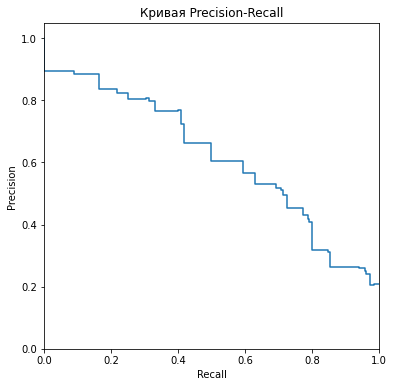

In [161]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid,
                                                       probabilities_valid[:, 1])
plt.figure(figsize=(6, 6))
plt.step(recall,
         precision,
         where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

AUC-ROC

In [162]:
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_dtс = roc_auc_score(target_valid,
                            probabilities_one_valid)
print('\nauc_roc_dtс =', auc_roc_dtс)


auc_roc_dtс = 0.8235890195616438


ROC-кривая

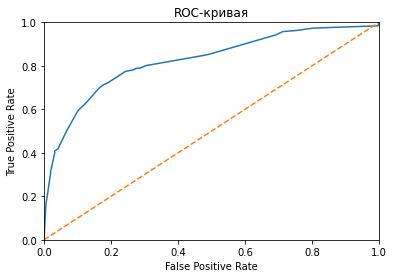

In [163]:
fpr, tpr, thresholds = roc_curve(target_valid,
                                 probabilities_one_valid)
plt.figure()
plt.plot(fpr,
         tpr)
plt.plot([0, 1],
         [0, 1],
         linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### LogisticRegression

In [164]:
model = LogisticRegression(random_state=1980,
                           solver='liblinear')
model.fit(features_train,
          target_train) 
predicted_valid = model.predict(features_valid)
accuracy_valid_lr = accuracy_score(target_valid,
                                   predicted_valid)
print('\nПравильность модели:')
print(accuracy_valid_lr)

print('\nМатрица ошибок:')
print(confusion_matrix(target_valid,
                       predicted_valid))

recall_score_lr = recall_score(target_valid,
                               predicted_valid)
print('\nПолнота:')
print(recall_score_lr)

precision_score_lr = precision_score(target_valid,
                                     predicted_valid)
print('\nТочность:')
print(precision_score_lr)

f1_score_lr = f1_score(target_valid,
                       predicted_valid)
print('\nF1-мера:')
print(f1_score_lr)


Правильность модели:
0.7788778877887789

Матрица ошибок:
[[1398   43]
 [ 359   18]]

Полнота:
0.04774535809018567

Точность:
0.29508196721311475

F1-мера:
0.08219178082191782


Частоты классов в результатах предсказаний LogisticRegression.


Частоты классов:
0   0.966
1   0.034
dtype: float64 



Text(0.5, 1.0, 'Частоты классов')

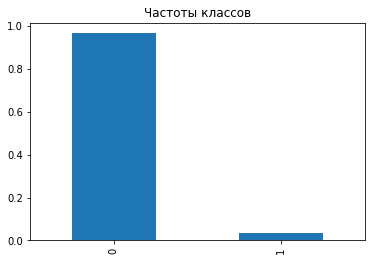

In [165]:
predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True)
print('\nЧастоты классов:')
print(class_frequency, '\n')
class_frequency.plot(kind='bar')
plt.title('Частоты классов')

Константная модель: любому объекту она прогнозирует класс «0».

In [166]:
target_pred_constant = pd.Series(0, index=target.index)
accuracy_score_lr = accuracy_score(target,
                                   target_pred_constant)
print('\nКонстантная модель:')
print(accuracy_score_lr) 


Константная модель:
0.7960620393796062


PR-кривая

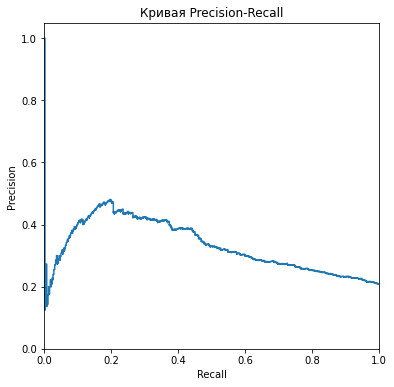

In [167]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid,
                                                       probabilities_valid[:, 1])
plt.figure(figsize=(6, 6))
plt.step(recall,
         precision,
         where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

AUC-ROC

In [168]:
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_lr = roc_auc_score(target_valid,
                           probabilities_one_valid)
print('auc_roc_lr:')
print(auc_roc_lr)

auc_roc_lr:
0.6643227790898231


ROC-кривая

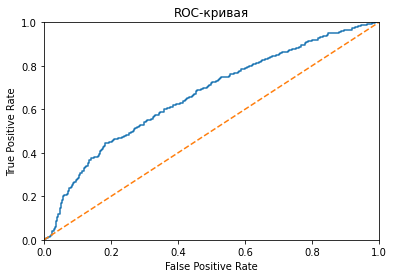

In [169]:
fpr, tpr, thresholds = roc_curve(target_valid, 
                                 probabilities_one_valid)
plt.figure()
plt.plot(fpr,
         tpr)
plt.plot([0, 1],
         [0, 1],
         linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### RandomForestRegressor

In [170]:
model = RandomForestRegressor(n_estimators=60,
                              max_depth=10,
                              random_state=1980) # выбираем наилучшую модель
model.fit(features_train,
          target_train)                          # обучаем модель на обучающей выборке
predicted_valid = model.predict(features_valid)

In [171]:
'''
# max_depth = range(1, 22, 2), n_estimators = range(100, 1001, 100)

best_est = 0
best_depth = 0
best_r2 = 0
for est in range(10, 1001, 100):
    for depth in range(6, 7, 1):
        model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=1980)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        r2 = model.score(features_valid, target_valid)
        if r2 > best_r2:
            best_r2 = r2
            best_est = est
            best_depth = depth
print("Наилучшая модель")
print("best_est = ", best_est)
print("best_depth = ", best_depth)
print("R2 на обучающей выборке: ", model.score(features_train, target_train))
print("R2 на валидационной выборке: ", model.score(features_valid, target_valid))
'''

'\n# max_depth = range(1, 22, 2), n_estimators = range(100, 1001, 100)\n\nbest_est = 0\nbest_depth = 0\nbest_r2 = 0\nfor est in range(10, 1001, 100):\n    for depth in range(6, 7, 1):\n        model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=1980)\n        model.fit(features_train, target_train)\n        predicted_valid = model.predict(features_valid)\n        r2 = model.score(features_valid, target_valid)\n        if r2 > best_r2:\n            best_r2 = r2\n            best_est = est\n            best_depth = depth\nprint("Наилучшая модель")\nprint("best_est = ", best_est)\nprint("best_depth = ", best_depth)\nprint("R2 на обучающей выборке: ", model.score(features_train, target_train))\nprint("R2 на валидационной выборке: ", model.score(features_valid, target_valid))\n'

In [172]:
model = RandomForestRegressor(n_estimators=410,
                              max_depth=7,
                              random_state=1980)
model.fit(features_train,
          target_train)
predicted_valid = model.predict(features_valid)
result_rfr = model.score(features_valid,
                         target_valid)   # считаем качество модели на валидационной выборке
print("R2 на обучающей выборке: ", model.score(features_train,
                                               target_train))
print("R2 на валидационной выборке: ", result_rfr)

R2 на обучающей выборке:  0.4751236917997982
R2 на валидационной выборке:  0.35557177625966063


Частоты классов в результатах предсказаний RandomForestRegressor.

In [173]:
predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True)
print('Частоты классов:')
print(class_frequency)

Частоты классов:
0.053   0.003
0.054   0.002
0.053   0.002
0.016   0.001
0.057   0.001
         ... 
0.078   0.001
0.060   0.001
0.175   0.001
0.072   0.001
0.457   0.001
Length: 1804, dtype: float64


Константная модель: любому объекту она прогнозирует класс «0».

In [174]:
target_pred_constant = pd.Series(0, index=target.index)
accuracy_score_rfr = accuracy_score(target,
                                    target_pred_constant)
print('\nКонстантная модель:')
print(accuracy_score_rfr)


Константная модель:
0.7960620393796062


AUC-ROC

In [175]:
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_rfr = roc_auc_score(target_valid,
                            probabilities_one_valid)
print('\nauc_roc_rfr_opt:')
print(auc_roc_rfr)


auc_roc_rfr_opt:
0.6643227790898231


ROC-кривая

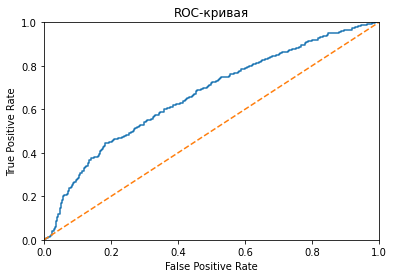

In [176]:
fpr, tpr, thresholds = roc_curve(target_valid,
                                 probabilities_one_valid)
plt.figure()
plt.plot(fpr,
         tpr)
plt.plot([0, 1],
         [0, 1],
         linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### RandomForestClassifier

In [177]:
'''
# max_depth = range(1, 22, 2), n_estimators = range(100, 1001, 100)

best_model_rfc = None
best_est_rfc = 0
best_result_rfc = 0
for est in range(100, 1001, 100):
    model_rfc = RandomForestClassifier(n_estimators=est, random_state=1980)
    model_rfc.fit(features_train, target_train)
    result_rfc = model_rfc.score(features_valid, target_valid) # считаем качество модели на валидационной выборке
    if result_rfc > best_result_rfc:
        best_est_rfc = est
        best_model_rfc = model_rfc # сохраняем наилучшую модель
        best_result_rfc = result_rfc #  сохраняем наилучшее значение метрики accuracy на валидационных данных
print("Наилучшая модель")
print("Точность наилучшей модели `Случайный лес`:", best_result_rfc)
print("Лучшая модель:", best_model_rfc)
print("best_est_rfc:", best_est_rfc)
print()
'''

'\n# max_depth = range(1, 22, 2), n_estimators = range(100, 1001, 100)\n\nbest_model_rfc = None\nbest_est_rfc = 0\nbest_result_rfc = 0\nfor est in range(100, 1001, 100):\n    model_rfc = RandomForestClassifier(n_estimators=est, random_state=1980)\n    model_rfc.fit(features_train, target_train)\n    result_rfc = model_rfc.score(features_valid, target_valid) # считаем качество модели на валидационной выборке\n    if result_rfc > best_result_rfc:\n        best_est_rfc = est\n        best_model_rfc = model_rfc # сохраняем наилучшую модель\n        best_result_rfc = result_rfc #  сохраняем наилучшее значение метрики accuracy на валидационных данных\nprint("Наилучшая модель")\nprint("Точность наилучшей модели `Случайный лес`:", best_result_rfc)\nprint("Лучшая модель:", best_model_rfc)\nprint("best_est_rfc:", best_est_rfc)\nprint()\n'

In [178]:
model_rfc = RandomForestClassifier(n_estimators=900,
                                   random_state=1980)
model_rfc.fit(features_train,
              target_train)
result_rfc = model_rfc.score(features_valid,
                             target_valid)   # считаем качество модели на валидационной выборке
print("\nТочность модели `Случайный лес`:", result_rfc)


Точность модели `Случайный лес`: 0.8575357535753575


Частоты классов в результатах предсказаний RandomForestClassifier.

In [179]:
predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True)
print('\nЧастоты классов:')
print(class_frequency)


Частоты классов:
0.053   0.003
0.054   0.002
0.053   0.002
0.016   0.001
0.057   0.001
         ... 
0.078   0.001
0.060   0.001
0.175   0.001
0.072   0.001
0.457   0.001
Length: 1804, dtype: float64


Константная модель: любому объекту она прогнозирует класс «0».

In [180]:
target_pred_constant = pd.Series(0, index=target.index)
accuracy_score_rfc = accuracy_score(target,
                                    target_pred_constant)
print('\nКонстантная модель:')
print(accuracy_score_rfc)


Константная модель:
0.7960620393796062


AUC-ROC

In [181]:
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_rfc = roc_auc_score(target_valid,
                            probabilities_one_valid)
print('\nauc_roc_rfc:')
print(auc_roc_rfc)
print()


auc_roc_rfc:
0.6643227790898231



ROC-кривая

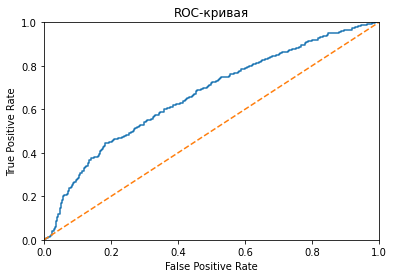

In [182]:
fpr, tpr, thresholds = roc_curve(target_valid,
                                 probabilities_one_valid)
plt.figure()
plt.plot(fpr,
         tpr)
plt.plot([0, 1],
         [0, 1],
         linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Все посчитанное собираем в табличку.

In [183]:
Name = ['Правильность модели',
        'Полнота',
        'Точность',
        'F1-мера',
        'AUC-ROC',
        'Константная модель'] 
dtс = [accuracy_valid_dtс,
       recall_score_dtс,
       precision_score_dtс,
       f1_score_dtс,
       auc_roc_dtс,
       accuracy_score_dtс]
lr = [accuracy_valid_lr,
      recall_score_lr,
      precision_score_lr,
      f1_score_lr,
      auc_roc_lr,
      accuracy_score_lr]
rfr = [result_rfr,
       'Нет',
       'Нет',
       'Нет',
       auc_roc_rfr,
       accuracy_score_rfr]
rfс = [result_rfc,
       'Нет',
       'Нет',
       'Нет',
       auc_roc_rfc,
       accuracy_score_rfc]
list_tuples = list(zip(Name,
                       dtс,
                       lr,
                       rfr,
                       rfс)) 
dframe = pd.DataFrame(list_tuples,
                      columns=['Name',
                               'dtс',
                               'lr',
                               'rfr',
                               'rfс']) 
dframe

,Name,dtс,lr,rfr,rfс
0,Правильность модели,0.850,0.779,0.356,0.858
1,Полнота,0.401,0.048,Нет,Нет
2,Точность,0.766,0.295,Нет,Нет
3,F1-мера,0.526,0.082,Нет,Нет
4,AUC-ROC,0.824,0.664,0.664,0.664
5,Константная модель,0.796,0.796,0.796,0.796


##### Вывод

    - Правильность модели максимальной получилась в RandomForestClassifier.
    - Удаление из признаков колонок с фамилиями и номерами строк повысило точность прогноза.
    - Не удалось достичь F1-меры не менее 0.59

## Борьба с дисбалансом

### Масштабируем признаки

In [184]:
numeric = [#'customer_id', 
           'credit_score', 
           'tenure',
           'balance', 
           'num_of_products', 
           'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
print(features_train.head(5))

      credit_score  age  tenure  balance  num_of_products  has_cr_card  \
1866        -0.967   70   1.378   -1.231           -0.923            1   
8535        -0.571   43  -1.040    0.130           -0.923            0   
2378        -0.312   38  -0.349    0.346           -0.923            1   
911         -0.041   53   0.342    0.547           -0.923            1   
6080         0.073   42  -1.040   -1.231           -0.923            0   

      is_active_member  estimated_salary  geography_germany  geography_spain  \
1866                 1             0.389                  0                0   
8535                 1            -1.662                  0                1   
2378                 1             0.171                  0                0   
911                  1             0.364                  0                1   
6080                 0             1.080                  0                1   

      gender_male  
1866            0  
8535            1  
2378          

Масштабирование улучшило точность предсказания.

Если его выполнить сразу после разбиения данных, то это не изменит результаты 
по оптимизированным данным, но уменьшит наглядность изменений происходящих после оптимизации.

### Увеличиваем выборку

In [185]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled,
                                                   target_upsampled,
                                                   random_state=1980)
    return features_upsampled,target_upsampled
features_upsampled, target_upsampled = upsample(features_train,
                                                target_train,
                                                3)
features_train = features_upsampled
target_train = target_upsampled
print("Сделано!")

Сделано!


### Уменьшаем выборки

In [186]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction,
                                                            random_state=1980)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction,
                                                        random_state=1980)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled,
                                                       target_downsampled,
                                                       random_state=1980)
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train,
                                                      target_train,
                                                      0.25)
features_train = features_downsampled
target_train = target_downsampled
print("Сделано!")

Сделано!


Этот раздел уменьшает правильность предсказания и F1-метрику.

Правильность модели RandomForestRegressor ушла в минус.

### DecisionTreeClassifier

In [187]:
best_depth = 0
best_f1_score_dtс = 0
for depth in range(17, 18, 1):                 # проверялось до 50
    model = DecisionTreeClassifier(random_state=1980,
                                   max_depth=17)
    model.fit(features_train,
              target_train) 
    predicted_valid = model.predict(features_valid)
    f1_score_dtс = f1_score(target_valid,
                            predicted_valid)
    if f1_score_dtс > best_f1_score_dtс:
        best_f1_score_dtс = f1_score_dtс
        best_depth = depth
accuracy_valid_dtс_opt = accuracy_score(target_valid,
                                        predicted_valid)
print('\nПравильность модели:')
print(accuracy_valid_dtс_opt)
print('best_depth', best_depth)

print('\nМатрица ошибок:')
print(confusion_matrix(target_valid, predicted_valid))

recall_score_dtс_opt = recall_score(target_valid, predicted_valid)
print('\nПолнота:')
print(recall_score_dtс_opt)

precision_score_dtс_opt = precision_score(target_valid, predicted_valid)
print('\nТочность:')
print(precision_score_dtс_opt)

f1_score_dtс_opt = f1_score(target_valid, predicted_valid)
print('\nF1-мера:')
print(f1_score_dtс_opt)


Правильность модели:
0.7062706270627063
best_depth 17

Матрица ошибок:
[[1019  422]
 [ 112  265]]

Полнота:
0.7029177718832891

Точность:
0.38573508005822416

F1-мера:
0.49812030075187963


Частоты классов в результатах предсказаний DecisionTreeClassifier.


Частоты классов:
0   0.622
1   0.378
dtype: float64 



Text(0.5, 1.0, 'Частоты классов')

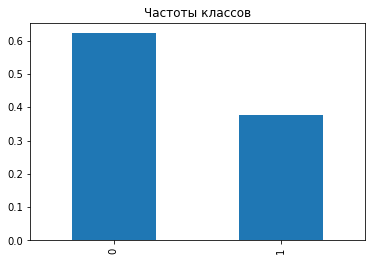

In [188]:
predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True)
print('\nЧастоты классов:')
print(class_frequency, '\n')
class_frequency.plot(kind='bar')
plt.title('Частоты классов')

Константная модель: любому объекту она прогнозирует класс «0».

In [189]:
target_pred_constant = pd.Series(0, index=target.index)
accuracy_score_dtс_opt = accuracy_score(target,
                                        target_pred_constant)
print('\nКонстантная модель:')
print(accuracy_score_dtс_opt) 


Константная модель:
0.7960620393796062


PR-кривая

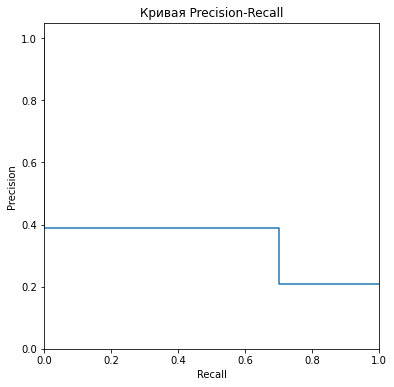

In [190]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid,
                                                       probabilities_valid[:, 1])
plt.figure(figsize=(6, 6))
plt.step(recall,
         precision,
         where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

AUC-ROC

In [191]:
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_dtс_opt = roc_auc_score(target_valid,
                                probabilities_one_valid)
print('\nauc_roc_dtс_opt:')
print(auc_roc_dtс_opt)


auc_roc_dtс_opt:
0.7050401559482896


ROC-кривая

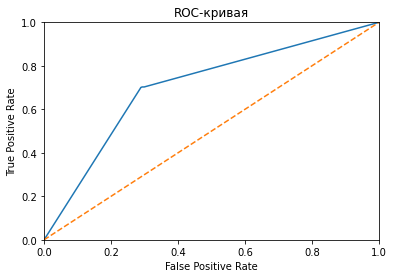

In [192]:
fpr, tpr, thresholds = roc_curve(target_valid,
                                 probabilities_one_valid)
plt.figure()
plt.plot(fpr,
         tpr)
plt.plot([0, 1],
         [0, 1],
         linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### LogisticRegression

In [193]:
model = LogisticRegression(random_state=1980,
                           solver='liblinear')
model.fit(features_train,
          target_train) 
predicted_valid = model.predict(features_valid)
accuracy_valid_lr_opt = accuracy_score(target_valid,
                                       predicted_valid)
print('\nПравильность модели:')
print(accuracy_valid_lr_opt)

print('\nМатрица ошибок:')
print(confusion_matrix(target_valid,
                       predicted_valid))

recall_score_lr_opt = recall_score(target_valid,
                                   predicted_valid)
print('\nПолнота:')
print(recall_score_lr_opt)

precision_score_lr_opt = precision_score(target_valid,
                                         predicted_valid)
print('\nТочность:')
print(precision_score_lr_opt)

f1_score_lr_opt = f1_score(target_valid,
                           predicted_valid)
print('\nF1-мера:')
print(f1_score_lr_opt)


Правильность модели:
0.41914191419141916

Матрица ошибок:
[[ 409 1032]
 [  24  353]]

Полнота:
0.9363395225464191

Точность:
0.2548736462093863

F1-мера:
0.40068104426787743


Частоты классов в результатах предсказаний LogisticRegression.


Частоты классов:
1   0.762
0   0.238
dtype: float64


Text(0.5, 1.0, 'Частоты классов')

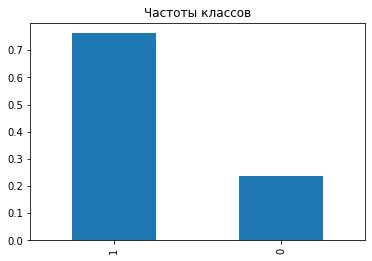

In [194]:
predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True)
print('\nЧастоты классов:')
print(class_frequency)
class_frequency.plot(kind='bar')
plt.title('Частоты классов')

Константная модель: любому объекту она прогнозирует класс «0».

In [195]:
target_pred_constant = pd.Series(0, index=target.index)
accuracy_score_lr_opt = accuracy_score(target,
                                       target_pred_constant)
print('\nКонстантная модель:')
print(accuracy_score_lr_opt) 


Константная модель:
0.7960620393796062


PR-кривая

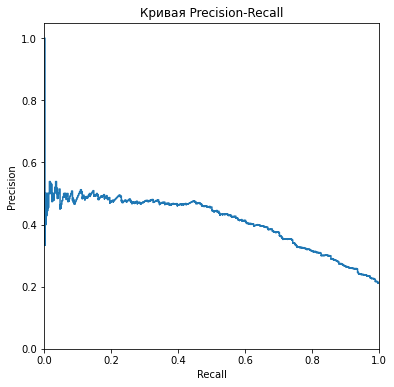

In [196]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid,
                                                       probabilities_valid[:, 1])
plt.figure(figsize=(6, 6))
plt.step(recall,
         precision,
         where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

AUC-ROC

In [197]:
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_lr_opt = roc_auc_score(target_valid,
                               probabilities_one_valid)
print('auc_roc_lr_opt:')
print(auc_roc_lr_opt)

auc_roc_lr_opt:
0.747279832565434


ROC-кривая

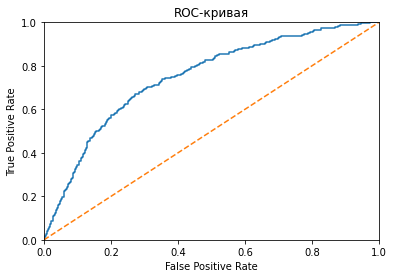

In [198]:
fpr, tpr, thresholds = roc_curve(target_valid,
                                 probabilities_one_valid)
plt.figure()
plt.plot(fpr,
         tpr)
plt.plot([0, 1],
         [0, 1],
         linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### RandomForestRegressor

In [199]:
'''
# max_depth = range(1, 22, 2), n_estimators = range(100, 1001, 100)

best_est = 0
best_depth = 0
best_r2 = 0
for est in range(100, 1001, 100):
    for depth in range(6, 7, 1):
        model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=1980)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        r2 = model.score(features_valid, target_valid)
        if r2 > best_r2:
            best_r2 = r2
            best_est = est
            best_depth = depth
print("Наилучшая модель")
print("best_est = ", best_est)
print("best_depth = ", best_depth)
print("R2 на обучающей выборке: ", model.score(features_train, target_train))
print("R2 на валидационной выборке: ", model.score(features_valid, target_valid))
'''

'\n# max_depth = range(1, 22, 2), n_estimators = range(100, 1001, 100)\n\nbest_est = 0\nbest_depth = 0\nbest_r2 = 0\nfor est in range(100, 1001, 100):\n    for depth in range(6, 7, 1):\n        model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=1980)\n        model.fit(features_train, target_train)\n        predicted_valid = model.predict(features_valid)\n        r2 = model.score(features_valid, target_valid)\n        if r2 > best_r2:\n            best_r2 = r2\n            best_est = est\n            best_depth = depth\nprint("Наилучшая модель")\nprint("best_est = ", best_est)\nprint("best_depth = ", best_depth)\nprint("R2 на обучающей выборке: ", model.score(features_train, target_train))\nprint("R2 на валидационной выборке: ", model.score(features_valid, target_valid))\n'

In [200]:
model = RandomForestRegressor(n_estimators=400,
                              max_depth=7,
                              random_state=1980)
model.fit(features_train,
          target_train)
predicted_valid = model.predict(features_valid)
result_rfr_opt = model.score(features_valid,
                             target_valid)   # считаем качество модели на валидационной выборке
print("\nR2 на обучающей выборке: ", model.score(features_train,
                                               target_train))
print("R2 на валидационной выборке: ", result_rfr_opt)


R2 на обучающей выборке:  0.5369630679902766
R2 на валидационной выборке:  -0.5733115651884677


Частоты классов в результатах предсказаний RandomForestRegressor.

In [201]:
predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True)
print('\nЧастоты классов:')
print(class_frequency)


Частоты классов:
0.856   0.001
0.618   0.001
0.984   0.001
0.239   0.001
0.362   0.001
         ... 
0.222   0.001
0.798   0.001
0.565   0.001
0.343   0.001
0.922   0.001
Length: 1818, dtype: float64


Константная модель: любому объекту она прогнозирует класс «0».

In [202]:
target_pred_constant = pd.Series(0, index=target.index)
accuracy_score_rfr_opt = accuracy_score(target,
                                        target_pred_constant)
print('\nКонстантная модель:')
print(accuracy_score_rfr_opt)


Константная модель:
0.7960620393796062


AUC-ROC

In [203]:
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_rfr_opt = roc_auc_score(target_valid,
                                probabilities_one_valid)
print('\nauc_roc_rfr_opt:')
print(auc_roc_rfr_opt)


auc_roc_rfr_opt:
0.747279832565434


ROC-кривая

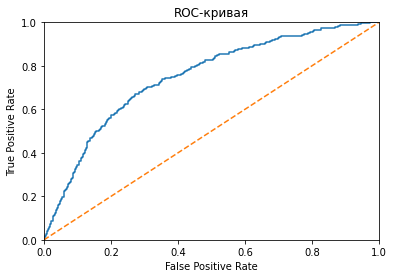

In [204]:
fpr, tpr, thresholds = roc_curve(target_valid,
                                 probabilities_one_valid)
plt.figure()
plt.plot(fpr,
         tpr)
plt.plot([0, 1],
         [0, 1],
         linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### RandomForestClassifier

In [205]:
'''
# max_depth = range(1, 22, 2), n_estimators = range(100, 1001, 100)

best_model_rfc_opt = None
best_est_rfc_opt = 0
best_result_rfc_opt = 0
for est in range(100, 1001, 100):
    model_rfc_opt = RandomForestClassifier(n_estimators=est, random_state=1980)
    model_rfc_opt.fit(features_train, target_train)
    result = model_rfc_opt.score(features_valid, target_valid) # считаем качество модели на валидационной выборке
    if result > best_result_rfc_opt:
        best_est_rfc_opt = est
        best_model_rfc_opt = model_rfc_opt # сохраняем наилучшую модель
        best_result_rfc_opt = result #  сохраняем наилучшее значение метрики accuracy на валидационных данных
print("Наилучшая модель")
print("Точность наилучшей модели `Случайный лес`:", best_result_rfc_opt)
print("Лучшая модель:", best_model_rfc_opt)
print()
'''

'\n# max_depth = range(1, 22, 2), n_estimators = range(100, 1001, 100)\n\nbest_model_rfc_opt = None\nbest_est_rfc_opt = 0\nbest_result_rfc_opt = 0\nfor est in range(100, 1001, 100):\n    model_rfc_opt = RandomForestClassifier(n_estimators=est, random_state=1980)\n    model_rfc_opt.fit(features_train, target_train)\n    result = model_rfc_opt.score(features_valid, target_valid) # считаем качество модели на валидационной выборке\n    if result > best_result_rfc_opt:\n        best_est_rfc_opt = est\n        best_model_rfc_opt = model_rfc_opt # сохраняем наилучшую модель\n        best_result_rfc_opt = result #  сохраняем наилучшее значение метрики accuracy на валидационных данных\nprint("Наилучшая модель")\nprint("Точность наилучшей модели `Случайный лес`:", best_result_rfc_opt)\nprint("Лучшая модель:", best_model_rfc_opt)\nprint()\n'

In [206]:
model_rfc_opt = RandomForestClassifier(n_estimators=900,
                                       random_state=1980)
model_rfc_opt.fit(features_train,
                  target_train)
result_rfc_opt = model_rfc_opt.score(features_valid,
                                     target_valid)   # считаем качество модели на валидационной выборке
print("\nТочность модели `Случайный лес`:", result_rfc_opt)


Точность модели `Случайный лес`: 0.6936193619361937


Частоты классов в результатах предсказаний RandomForestClassifier.

In [207]:
predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True)
print('\nЧастоты классов:')
print(class_frequency)


Частоты классов:
0.856   0.001
0.618   0.001
0.984   0.001
0.239   0.001
0.362   0.001
         ... 
0.222   0.001
0.798   0.001
0.565   0.001
0.343   0.001
0.922   0.001
Length: 1818, dtype: float64


Константная модель: любому объекту она прогнозирует класс «0».

In [208]:
target_pred_constant = pd.Series(0, index=target.index)
accuracy_score_rfc_opt = accuracy_score(target,
                                        target_pred_constant)
print('\nКонстантная модель:')
print(accuracy_score_rfc_opt)


Константная модель:
0.7960620393796062


AUC-ROC

In [209]:
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_rfc_opt = roc_auc_score(target_valid,
                                probabilities_one_valid)
print('\nauc_roc_rfr_opt:')
print(auc_roc_rfc_opt)


auc_roc_rfr_opt:
0.747279832565434


ROC-кривая

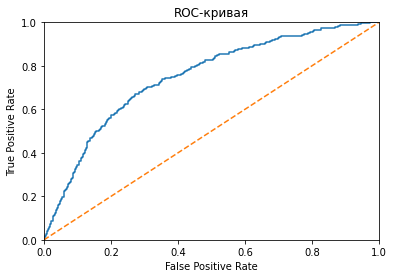

In [210]:
fpr, tpr, thresholds = roc_curve(target_valid,
                                 probabilities_one_valid)
plt.figure()
plt.plot(fpr,
         tpr)
plt.plot([0, 1],
         [0, 1],
         linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Табличка с результатами расчетов.

In [211]:
Name = ['Правильность модели',
        'Полнота',
        'Точность',
        'F1-мера',
        'AUC-ROC',
        'Константная модель'] 
dtс = [accuracy_valid_dtс,
       recall_score_dtс,
       precision_score_dtс,
       f1_score_dtс,
       auc_roc_dtс,
       accuracy_score_dtс]
dtс_opt = [accuracy_valid_dtс_opt,
           recall_score_dtс_opt,
           precision_score_dtс_opt,
           f1_score_dtс_opt,
           auc_roc_dtс_opt,
           accuracy_score_dtс_opt]
lr = [accuracy_valid_lr,
      recall_score_lr,
      precision_score_lr,
      f1_score_lr,
      auc_roc_lr,
      accuracy_score_lr]
lr_opt = [accuracy_valid_lr_opt,
          recall_score_lr_opt,
          precision_score_lr_opt,
          f1_score_lr_opt,
          auc_roc_lr_opt,
          accuracy_score_lr_opt]
rfr = [result_rfr,
       'Нет',
       'Нет',
       'Нет',
       auc_roc_rfr,
       accuracy_score_rfr]
rfr_opt = [result_rfr_opt,
           'Нет',
           'Нет',
           'Нет',
           auc_roc_rfr_opt,
           accuracy_score_rfr_opt]
rfc = [result_rfc,
       'Нет',
       'Нет',
       'Нет',
       auc_roc_rfc,
       accuracy_score_rfc]
rfc_opt = [result_rfc_opt,
           'Нет',
           'Нет',
           'Нет',
           auc_roc_rfc_opt,
           accuracy_score_rfc_opt]
list_tuples = list(zip(Name,
                       dtс,
                       dtс_opt,
                       lr,
                       lr_opt,
                       rfr,
                       rfr_opt,
                       rfc,
                       rfc_opt)) 
dframe = pd.DataFrame(list_tuples,
                      columns=['Name',
                               'dtс',
                               'dtс_opt',
                               'lr',
                               'lr_opt',
                               'rfr',
                               'rfr_opt',
                               'rfc',
                               'rfc_opt']) 
dframe

,Name,dtс,dtс_opt,lr,lr_opt,rfr,rfr_opt,rfc,rfc_opt
0,Правильность модели,0.850,0.706,0.779,0.419,0.356,-0.573,0.858,0.694
1,Полнота,0.401,0.703,0.048,0.936,Нет,Нет,Нет,Нет
2,Точность,0.766,0.386,0.295,0.255,Нет,Нет,Нет,Нет
3,F1-мера,0.498,0.498,0.082,0.401,Нет,Нет,Нет,Нет
4,AUC-ROC,0.824,0.705,0.664,0.747,0.664,0.747,0.664,0.747
5,Константная модель,0.796,0.796,0.796,0.796,0.796,0.796,0.796,0.796


##### Вывод

    - Увеличение выборки позволило увеличить точность прогноза.
    - Уменьшение выборки только уменьшало точность прогноза.
    - Правильность предсказания у модели RandomForestClassifier_optimized получилась максимальной.
    - Максимальную F1-меру удалось получить только 0.46 в DecisionTreeClassifier и DecisionTreeClassifier_optimized.

## Тестирование модели

Для тестирования выбираем модель с наибольшим AUC-ROC = 0.817598.

In [212]:
model = DecisionTreeClassifier(random_state=1980,
                               max_depth=6)
model.fit(features_train,
          target_train) 
predicted_test = model.predict(features_test)
f1_score_dtс_test = f1_score(target_test,
                             predicted_test)
print('\nf1_score_dtс_val:', f1_score_dtс)
print('f1_score_dtс_test:', f1_score_dtс_test)


f1_score_dtс_val: 0.49812030075187963
f1_score_dtс_test: 0.3358024691358024


##### Вывод общий

    - Правильность модели максимальной получилась в RandomForestClassifier.
    - Удаление из признаков колонок с фамилиями и номерами строк повысило точность прогноза.
    - Не удалось достичь F1-меры не менее 0.59.
      Но лучшей по ней оказалась модель DecisionTreeClassifier.
    - На тестовой выборке F1-мера уменьшилась.